In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# import data

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print("The shape of train data", train.shape)
print("The shape of the test data", test.shape)

The shape of train data (42000, 785)
The shape of the test data (28000, 784)


In [3]:
# the images are flattened (each row contains values for a single image)
# we need to reshape it to get the immage matrix (grayscale pixel values in a 28 x 28 matrix)
# but first, we seprate labels and predictors (y and x respectively)
# and convert from Pandas dataframe into numpy matrix (that's what the .values does)

X = (train.iloc[:, 1:].values).astype('float32')
y = (train.iloc[:, 0].values).astype('int32')
X_test = test.values.astype('float32')

In [4]:
#reshape the matrix
img_rows, img_cols = 28, 28
num_classes = 10 # digits 0 - 9

X_train = X.reshape(X.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)

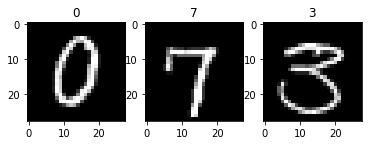

In [5]:
# plot the images for sanity check

for i in range(5, 8):
    plt.subplot(130 + (-4+i))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y[i])

In [6]:
# add another dimension for color channel
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

In [7]:
# normalize the pixel values for easier processing
X_train = X_train / 255
X_test = X_test / 255

In [8]:
# encode labels with one-hot encoder (convert to separate categories)
y_train = to_categorical(y)

In [9]:
# split data into train and validation set (used only for image augmentation, otherwise done at fitting)
X_gen, X_val, y_gen, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# apply some augmentation to the images data to increase training data
datagen = ImageDataGenerator(rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1)
datagen.fit(X_gen)

In [10]:
# assemble the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5),
                activation='relu',
                padding='same', # pads the "frames" of the image with 0's, so that convolution reaches the edges
                input_shape=(img_rows, img_cols, 1)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=(5, 5),
                padding='same',
                activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(12, kernel_size=(3, 3),
                padding='same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, kernel_size=(3, 3),
                padding='same',
                activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3),
                padding='same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [11]:
# compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [12]:
# show the summary of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 12)        3468      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 12)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 12)        0         
__________

In [13]:
# train the model
model.fit_generator(datagen.flow(X_gen, y_gen, batch_size=420),
                   epochs=20,
                   validation_data=(X_val, y_val))

Epoch 1/20
 2/90 [..............................] - ETA: 1:02:46 - loss: 2.3015 - acc: 0.1048

KeyboardInterrupt: 

In [ ]:
# make predictions
preds = model.predict_classes(X_test)

In [ ]:
# save prediction into a Pandas dataframe and save it to .csv
submission = pd.DataFrame({'ImageId': list(range(1, len(preds)+1)), 'Label': preds})

In [ ]:
submission.to_csv('submission.csv', index=False)